## GPT/Claude based Schematic component recognition

OPENAI_API_KEY loaded successfully.
[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "simple_circuit.png",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, provide the following information:\n   - A count of how many components are in the image\n   - A list of wires present on this schematic drawing, including start and end position on the image (you may approaximate using pixel locations)\n   - A list of components present on this schematic drawing, including their name, position on the image, and orientation (you may approaximate using pixel locations)\n   - A list of connections made by the components, you must make sure all the referneces stays consistent throught your answer!\n   Please just reply ONLY in JSON output and nothing else!\n   "
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "simple_circuit.png",
  "prompt": "\n   Given the image w
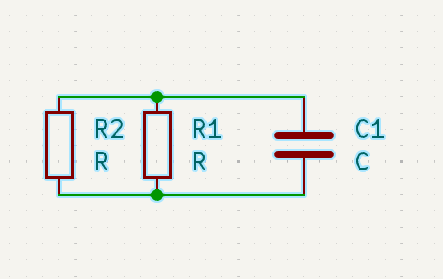

In [1]:
from LLMToSchematics import image_to_schematics

result= image_to_schematics("simple_circuit.png")

# GPT Output processing

In [3]:
# save the result

# save the result dictionary to a file
import json
with open('result.json', 'w') as f:
    json.dump(result, f, indent=4)




In [6]:
# load the dictionary from the file
import json
with open('result.json', 'r') as f:
    result = json.load(f)

In [3]:
# iterate through the list of dicts results and remove empty dicts
for i in range(len(result['detected_components'])):
    if not result['detected_components'][i]:
        del result['detected_components'][i]
for component in result["detected_components"]:
    print(component["lib_id"])

R
R
C


In [4]:
import kicad_utils
kicad_schematic_path = "testProject/testProject.kicad_sch"
list_of_component_dict =[]


for symbol in result["detected_components"]:
    print(symbol["lib_id"], symbol["x"], symbol["y"], symbol["angle"], symbol["reference"])
    
    # Add the component to the list
    list_of_component_dict.append({"lib_id": kicad_utils.match_libId(symbol["lib_id"]), "x": symbol["x"], "y": symbol["y"], "angle": symbol["angle"], "reference_name": symbol["reference"]})


    

R 75 75 0 R2
R 125 75 0 R1
C 225 75 0 C1


In [12]:
kicad_utils.modify_kicad_sch_file(components = list_of_component_dict, file_path=kicad_schematic_path)

Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "dea647a7-e0d8-45e4-9bce-23c7e387cf2b")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:C"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0.254)\n\t\t)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "C"\n\t\t\t(at 0.635 2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "C"\n\t\t\t(at 0.635 -2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at 0.9652 -3.81 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Description"

In [11]:
# kicad_utils.modify_kicad_sch_file(wires= result['detected_wires'], file_path=kicad_schematic_path)

Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "dea647a7-e0d8-45e4-9bce-23c7e387cf2b")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:C"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0.254)\n\t\t)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "C"\n\t\t\t(at 0.635 2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "C"\n\t\t\t(at 0.635 -2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at 0.9652 -3.81 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Description"

In [10]:
for connection in result["component_connections"]:
    print(connection['componentA_reference'], connection['componentA_pin'], connection['componentB_reference'], connection['componentB_pin'])

    

R2 1 R1 1
R2 2 R1 2
R1 1 C1 1
R1 2 C1 2


In [ ]:
# code which maps R2.1 to x and y position


# THIS IS THE MOST IMPORTANT CELL

In [50]:
# result["component_connections"][0]['componentA_reference']
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []

for symbol in schem.symbol:
    print(symbol.property.Reference.value)
    
print(schem.symbol[0].pin[0].location.x)

R2
R1
C1
75


In [55]:
def find_component_in_schem(component_reference, skip_schematic):
    for symbol in skip_schematic.symbol:
        if symbol.property.Reference.value == component_reference:
            return symbol
found_symbol = find_component_in_schem("R2", schem)
found_symbol.pin[0].location.x

75

In [62]:
# Pseudo code

wire_list = []


# make a copy of detected connections
all_connections = result["component_connections"].copy()

# Iterate through the list of generated components in kicad shematic
for curr_component in schem.symbol:
    print(curr_component.property.Reference.value)
    curr_component_ref = curr_component.property.Reference.value
#   iterate through the list of detected connections
    for curr_connection in all_connections:
        # if curr component is compA in curr connection
        if curr_connection['componentA_reference'] == curr_component_ref:
            curr_component_A_pin = curr_component.pin[curr_connection['componentA_pin']-1]
            #find component B
            curr_component_B = find_component_in_schem(curr_connection['componentB_reference'], schem)
            curr_component_B_pin = curr_component_B.pin[curr_connection['componentB_pin']-1]
            # add a wire to connect
            wire_list.append({"x": curr_component_A_pin.location.x, "y": curr_component_A_pin.location.y, "end_x": curr_component_B_pin.location.x, "end_y":curr_component_B_pin.location.y})
            # print(f"")
            # remove connection from all_connections
        
        # if curr component is compB in curr connection
        elif curr_connection['componentB_reference'] == curr_component_ref:
            print(curr_connection)
            # add a wire to connect
            # wire_list.append({"x": curr_component., "y": , "end_x": , "end_y": })

            # remove connection from all_connections
print("Wire List")
print(wire_list)

R2
R1
{'componentA_reference': 'R2', 'componentA_pin': 1, 'componentB_reference': 'R1', 'componentB_pin': 1}
{'componentA_reference': 'R2', 'componentA_pin': 2, 'componentB_reference': 'R1', 'componentB_pin': 2}
C1
{'componentA_reference': 'R1', 'componentA_pin': 1, 'componentB_reference': 'C1', 'componentB_pin': 1}
{'componentA_reference': 'R1', 'componentA_pin': 2, 'componentB_reference': 'C1', 'componentB_pin': 2}
Wire List
[{'x': 75, 'y': 71.19, 'end_x': 125, 'end_y': 78.81}, {'x': 75, 'y': 78.81, 'end_x': 125, 'end_y': 71.19}, {'x': 125, 'y': 78.81, 'end_x': 225, 'end_y': 71.19}, {'x': 125, 'y': 71.19, 'end_x': 225, 'end_y': 78.81}]


In [63]:
wire_list

[{'x': 75, 'y': 71.19, 'end_x': 125, 'end_y': 78.81},
 {'x': 75, 'y': 78.81, 'end_x': 125, 'end_y': 71.19},
 {'x': 125, 'y': 78.81, 'end_x': 225, 'end_y': 71.19},
 {'x': 125, 'y': 71.19, 'end_x': 225, 'end_y': 78.81}]

In [65]:
import kicad_utils
kicad_schematic_path = "testProject/testProject.kicad_sch"
kicad_utils.modify_kicad_sch_file(wires= wire_list, file_path=kicad_schematic_path)

NameError: name 'kicad_schematic_path' is not defined

In [ ]:
# find a symbol by reference "R1" using skip library


schem.symbol

In [15]:
import skip
schem = skip.Schematic("testProject/testProject.kicad_sch")
wire_list = []


print(schem.symbol[0].pin[0].location.x)

75


In [49]:
wire_list = []
wire_list.append({"x": 121.92, "y": 67.31, "end_x": 156.21, "end_y": 67.31})
wire_list.append({"x": 1221.92, "y": 672.31, "end_x": 156.21, "end_y": 67.31})

print(wire_list)

[{'x': 121.92, 'y': 67.31, 'end_x': 156.21, 'end_y': 67.31}, {'x': 1221.92, 'y': 672.31, 'end_x': 156.21, 'end_y': 67.31}]


In [14]:

for connection in result["component_connections"]:
    wire_list.append({"x":, "y": 67.31, "end_x": 156.21, "end_y": 67.31})
    

for component in schem.symbol:
    print(component.pin[0].location.x)


SyntaxError: expression expected after dictionary key and ':' (2901676847.py, line 8)

In [18]:
import kicad_utils
temp_file_path = "testProject/testProject.kicad_sch"

temp_components = [
    # {"lib_id": ":SW_DPST_x2", "x": 143.51, "y": 77.47, "angle":0, "reference_name": "SW1A"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    {"lib_id": "Device:R", "x": 146.05, "y": 53.34, "angle":90, "reference_name": "R1"}
]

# kicad_utils.extract_symbol_definition("Device:R")
# kicad_utils.modify_kicad_sch_file(components = temp_components, file_path=temp_file_path)
kicad_utils.create_kicad_sch_file(components = temp_components,)


Reading file /usr/share/kicad/symbols/Device.kicad_sym
Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "59526c9f-d2d4-4c47-ba25-9347dc717d36")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:R"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0)\n\t\t)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "R"\n\t\t\t(at 2.032 0 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "R"\n\t\t\t(at 0 0 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at -1.778 0 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Description" "Resistor"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t

## Try adding wires


In [43]:
import skip


# load a schematic
schem = skip.Schematic("testProject/testProject.kicad_sch")


In [49]:
# # print(schem.symbol.R1.location)
# for component in schem.symbol:
    
#     print(component.value)

print(schem.symbol.R3.pin[0].location.x)
    # print(type(component))

114.3
